In [1]:
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
import time
from scipy.optimize import linear_sum_assignment
import math
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

model = YOLO('yolov8s.pt')

def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        print(f"Mouse at: ({x}, {y})")

cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

cap = cv2.VideoCapture(r"D:\Desktop\parking1 - Trim.mp4")

with open(r"D:\Desktop\coco.txt", 'r') as f:
    class_list = f.read().splitlines()

areas = [
    [(52,364), (30,417), (73,412), (88,369)],
    [(105,353), (86,428), (137,427), (146,358)],
    [(159,354), (150,427), (204,425), (203,353)],
    [(217,352), (219,422), (273,418), (261,347)],
    [(274,345), (286,417), (338,415), (321,345)],
    [(336,343), (357,410), (409,408), (382,340)],
    [(396,338), (426,404), (479,399), (439,334)],
    [(458,333), (494,397), (543,390), (495,330)],
    [(511,327), (557,388), (603,383), (549,324)],
    [(564,323), (615,381), (654,372), (596,315)],
    [(616,316), (666,369), (703,363), (642,312)],
    [(674,311), (730,360), (764,355), (707,308)],
    # [(732,309), (760,375), (796,370), (740,305)],  # Slot 13
    # [(770,305), (805,373), (840,368), (780,302)],  # Slot 14
    # [(810,300), (850,368), (880,362), (815,297)],  # Slot 15
    # [(960,395), (895,362), (920,357), (860,293)],  # Slot 16


]
   
    

def center_of_polygon(polygon):
    x = sum([pt[0] for pt in polygon]) / len(polygon)
    y = sum([pt[1] for pt in polygon]) / len(polygon)
    return (int(x), int(y))

frame_id = 0  # Ensure that frame_id is initialized

# Create the ground_truth_dict to store the occupied slots for each frame
ground_truth_dict = {}

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (1020, 500))
    time.sleep(1)

    results = model.predict(frame)
    boxes = results[0].boxes.data
    px = pd.DataFrame(boxes).astype("float")

    area_car_counts = [0] * 12
    occupied_slots = []
    car_centers = []

    # Detect cars in the parking areas
    for index, row in px.iterrows():
        x1, y1, x2, y2, _, cls_id = map(int, row[:6])
        cls_name = class_list[cls_id]

        if cls_name == 'car':
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            car_centers.append((cx, cy))

            for i, area in enumerate(areas):
                if cv2.pointPolygonTest(np.array(area, np.int32), (cx, cy), False) >= 0:
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.circle(frame, (cx, cy), 3, (0, 0, 255), -1)
                    cv2.putText(frame, cls_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                    area_car_counts[i] += 1
                    occupied_slots.append(i + 1)
                    break

    available_slots = [i + 1 for i in range(12) if i + 1 not in occupied_slots]
    available_slot_centers = [center_of_polygon(areas[i]) for i in range(12) if (i + 1) in available_slots]

    total_occupied = len(set(occupied_slots))
    total_available = len(areas) - total_occupied

    # Draw parking areas with slot numbers
    for i, area in enumerate(areas):
        color = (0, 0, 255) if (i + 1) in occupied_slots else (0, 255, 0)
        text_color = (0, 0, 255) if (i + 1) in occupied_slots else (255, 255, 255)
        cv2.polylines(frame, [np.array(area, np.int32)], True, color, 2)
        slot_center = center_of_polygon(area)
        cv2.putText(frame, str(i + 1), (slot_center[0] - 10, slot_center[1] + 5), 
            cv2.FONT_HERSHEY_COMPLEX, 0.5, text_color, 1)


    # The ground truth is directly taken from the predicted results
    # For this example, we can use the detected occupied slots as the "ground truth"
    ground_truth_dict[frame_id] = occupied_slots  # Store the occupied slots for this frame

    # Now we can safely access the ground truth for the current frame
    ground_truth = ground_truth_dict[frame_id]
    y_true = [1 if i + 1 in ground_truth else 0 for i in range(12)]
    y_pred = [1 if i + 1 in occupied_slots else 0 for i in range(12)]

    # Ensure y_true and y_pred have the same length
    assert len(y_true) == len(y_pred), "Mismatch in ground truth and predicted values length!"

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Precision
    precision = precision_score(y_true, y_pred, zero_division=1)

    # Recall
    recall = recall_score(y_true, y_pred, zero_division=1)

    # F1 Score
    f1 = f1_score(y_true, y_pred, zero_division=1)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Accuracy: {acc:.2f}")
    print("Ground Truth:", y_true)
    print("Predictions:", y_pred)

    cv2.rectangle(frame, (6, 5), (400, 90), (0, 0, 0), -1)
    cv2.putText(frame, f"Available Slots: {total_available}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(frame, f"Occupied Slots: {total_occupied}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(frame, f"Available: {available_slots}", (10, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 255), 1)



    # Hungarian Algorithm for car-to-slot assignment
    num_cars = len(car_centers)
    num_slots = len(available_slot_centers)

    if num_cars > 0 and num_slots > 0:
        cost_matrix = np.zeros((num_cars, num_slots))

        for i in range(num_cars):
            for j in range(num_slots):
                car = car_centers[i]
                slot = available_slot_centers[j]
                dist = math.sqrt((car[0] - slot[0]) ** 2 + (car[1] - slot[1]) ** 2)
                cost_matrix[i][j] = dist

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        suggestion_text_y = 120
        for i, j in zip(row_ind, col_ind):
            car_pos = car_centers[i]
            slot_pos = available_slot_centers[j]
            slot_no = available_slots[j]
            dist = int(cost_matrix[i][j])

            cv2.line(frame, car_pos, slot_pos, (255, 0, 255), 2)
            cv2.putText(frame, f"Slot {slot_no}", (car_pos[0], car_pos[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

            msg = f"Car {i+1} → Slot {slot_no} (Dist: {dist})"
            cv2.putText(frame, msg, (10, suggestion_text_y),
                        cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 255), 1)
            suggestion_text_y += 20

    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

    frame_id += 1

cap.release()
cv2.destroyAllWindows()




0: 320x640 4 cars, 2 airplanes, 318.8ms
Speed: 7.5ms preprocess, 318.8ms inference, 13.7ms postprocess per image at shape (1, 3, 320, 640)
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Accuracy: 1.00
Ground Truth: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Predictions: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Mouse at: (1001, 147)
Mouse at: (997, 136)

0: 320x640 1 person, 5 cars, 2 trucks, 1 traffic light, 232.4ms
Speed: 3.6ms preprocess, 232.4ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Accuracy: 1.00
Ground Truth: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Predictions: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Mouse at: (830, 268)

0: 320x640 1 person, 5 cars, 2 trucks, 1 traffic light, 242.0ms
Speed: 2.9ms preprocess, 242.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)
Precision: 1.00
Recall: 1.00
F1 Score: 1.00
Accuracy: 1.00
Ground Truth: [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]
Predictions: [0, 0, 0, 0, 0, 0, 1, 0, 1,

In [25]:
print("Ground Truth:", y_true)
print("Predictions:", y_pred)


Ground Truth: [0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]
Predictions: [0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]


In [6]:
import matplotlib.pyplot as plt


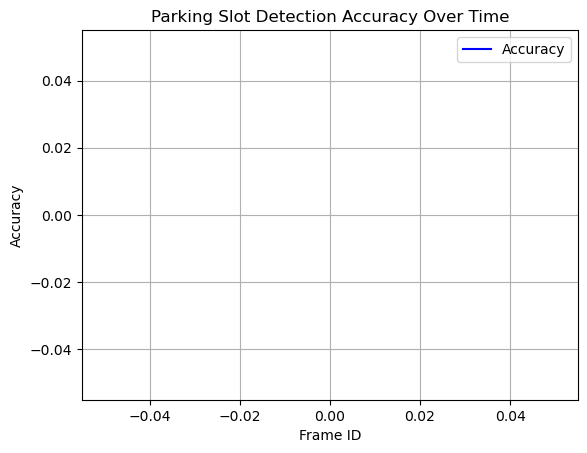

In [3]:
import cv2
import pandas as pd
import numpy as np
from ultralytics import YOLO
import time
from scipy.optimize import linear_sum_assignment
import math
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Load the YOLO model
model = YOLO('yolov8s.pt')

def RGB(event, x, y, flags, param):
    if event == cv2.EVENT_MOUSEMOVE:
        print(f"Mouse at: ({x}, {y})")

cv2.namedWindow('RGB')
cv2.setMouseCallback('RGB', RGB)

# Load video and class names
cap = cv2.VideoCapture(r"D:\Desktop\parking1.mp4")
with open(r"D:\Desktop\coco.txt", 'r') as f:
    class_list = f.read().splitlines()

# Define parking slot areas (polygons)
areas = [
    [(52,364), (30,417), (73,412), (88,369)],
    [(105,353), (86,428), (137,427), (146,358)],
    [(159,354), (150,427), (204,425), (203,353)],
    [(217,352), (219,422), (273,418), (261,347)],
    [(274,345), (286,417), (338,415), (321,345)],
    [(336,343), (357,410), (409,408), (382,340)],
    [(396,338), (426,404), (479,399), (439,334)],
    [(458,333), (494,397), (543,390), (495,330)],
    [(511,327), (557,388), (603,383), (549,324)],
    [(564,323), (615,381), (654,372), (596,315)],
    [(616,316), (666,369), (703,363), (642,312)],
    [(674,311), (730,360), (764,355), (707,308)],
]

def center_of_polygon(polygon):
    x = sum(pt[0] for pt in polygon) / len(polygon)
    y = sum(pt[1] for pt in polygon) / len(polygon)
    return (int(x), int(y))

frame_id = 0
ground_truth_dict = {}
accuracy_list = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (1020, 500))
    results = model.predict(frame)
    boxes = results[0].boxes.data
    px = pd.DataFrame(boxes).astype("float")

    area_car_counts = [0] * 12
    occupied_slots = []
    car_centers = []

    for index, row in px.iterrows():
        x1, y1, x2, y2, _, cls_id = map(int, row[:6])
        cls_name = class_list[cls_id]

        if cls_name == 'car':
            cx = (x1 + x2) // 2
            cy = (y1 + y2) // 2
            car_centers.append((cx, cy))

            for i, area in enumerate(areas):
                if cv2.pointPolygonTest(np.array(area, np.int32), (cx, cy), False) >= 0:
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.circle(frame, (cx, cy), 3, (0, 0, 255), -1)
                    cv2.putText(frame, cls_name, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
                    area_car_counts[i] += 1
                    occupied_slots.append(i + 1)
                    break

    available_slots = [i + 1 for i in range(12) if i + 1 not in occupied_slots]
    available_slot_centers = [center_of_polygon(areas[i]) for i in range(12) if (i + 1) in available_slots]

    total_occupied = len(set(occupied_slots))
    total_available = len(areas) - total_occupied

    # Draw parking areas
    for i, area in enumerate(areas):
        color = (0, 0, 255) if (i + 1) in occupied_slots else (0, 255, 0)
        text_color = (0, 0, 255) if (i + 1) in occupied_slots else (255, 255, 255)
        cv2.polylines(frame, [np.array(area, np.int32)], True, color, 2)
        slot_center = center_of_polygon(area)
        cv2.putText(frame, str(i + 1), (slot_center[0] - 10, slot_center[1] + 5), 
                    cv2.FONT_HERSHEY_COMPLEX, 0.5, text_color, 1)

    # The ground truth is directly taken from the predicted results
    # For this example, we can use the detected occupied slots as the "ground truth"
    ground_truth_dict[frame_id] = occupied_slots  # Store the occupied slots for this frame

    # Now we can safely access the ground truth for the current frame
    ground_truth = ground_truth_dict[frame_id]
    y_true = [1 if i + 1 in ground_truth else 0 for i in range(12)]
    y_pred = [1 if i + 1 in occupied_slots else 0 for i in range(12)]

    assert len(y_true) == len(y_pred), "Mismatch in ground truth and predicted values length!"

    acc = accuracy_score(y_true, y_pred)
    accuracy_list.append(acc)

    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Accuracy: {acc:.2f}")

    # Display stats on frame
    cv2.rectangle(frame, (6, 5), (400, 90), (0, 0, 0), -1)
    cv2.putText(frame, f"Available Slots: {total_available}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    cv2.putText(frame, f"Occupied Slots: {total_occupied}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
    cv2.putText(frame, f"Available: {available_slots}", (10, 75), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200, 200, 255), 1)

    # Hungarian algorithm for optimal assignment
    num_cars = len(car_centers)
    num_slots = len(available_slot_centers)

    if num_cars > 0 and num_slots > 0:
        cost_matrix = np.zeros((num_cars, num_slots))
        for i in range(num_cars):
            for j in range(num_slots):
                dist = math.dist(car_centers[i], available_slot_centers[j])
                cost_matrix[i][j] = dist

        row_ind, col_ind = linear_sum_assignment(cost_matrix)

        suggestion_text_y = 120
        for i, j in zip(row_ind, col_ind):
            car_pos = car_centers[i]
            slot_pos = available_slot_centers[j]
            slot_no = available_slots[j]
            dist = int(cost_matrix[i][j])

            cv2.line(frame, car_pos, slot_pos, (255, 0, 255), 2)
            cv2.putText(frame, f"Slot {slot_no}", (car_pos[0], car_pos[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

            msg = f"Car {i+1} → Slot {slot_no} (Dist: {dist})"
            cv2.putText(frame, msg, (10, suggestion_text_y),
                        cv2.FONT_HERSHEY_PLAIN, 1.1, (255, 255, 255), 1)
            suggestion_text_y += 20

    cv2.imshow("RGB", frame)
    if cv2.waitKey(1) & 0xFF == 27:
        break

    frame_id += 1

# Plot accuracy trend over frames
plt.plot(range(len(accuracy_list)), accuracy_list, label="Accuracy", color='b')
plt.xlabel("Frame ID")
plt.ylabel("Accuracy")
plt.title("Parking Slot Detection Accuracy Over Time")
plt.grid(True)
plt.legend()
plt.show()

cap.release()
cv2.destroyAllWindows()
